# Basic Variational Autoencoder (VAE)

A simple implementation of VAE with MNIST dataset using Hugging Face datasets.

## Imports and Setup

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Data Loading with Hugging Face

In [12]:
# Load MNIST dataset from Hugging Face
dataset = load_dataset("mnist")
print(f"Dataset info: {dataset}")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        
        if self.transform:
            image = self.transform(image)
        
        return image, item['label']

# Create datasets
train_dataset = MNISTDataset(dataset['train'], transform=transform)
test_dataset = MNISTDataset(dataset['test'], transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Dataset info: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Train samples: 60000
Test samples: 10000
Batch size: 128


## Data Visualization

Batch shape: torch.Size([128, 1, 28, 28])


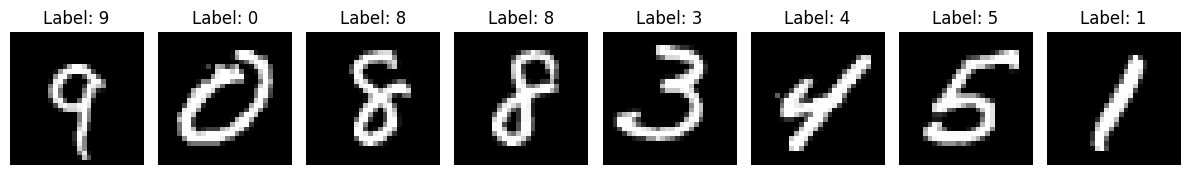

In [13]:
# Visualize some samples
def show_images(images, labels, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        img = images[i].squeeze().cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
print(f"Batch shape: {sample_images.shape}")
show_images(sample_images, sample_labels)

## VAE Model Architecture

In [33]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Output in [-1, 1] to match our normalization
        )
    
    def encode(self, x):
        # logvar = log(σ²)
        # σ² = exp(logvar)
        # σ = sqrt(σ²) = sqrt(exp(logvar)) = exp(logvar/2) = exp(0.5 * logvar)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Create model
model = VAE().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

Model parameters: 1009684
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (fc_mu): Linear(in_features=400, out_features=50, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Tanh()
  )
)


## VAE Loss Function (Reconstruction + KL Divergence)

In [34]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction Loss + β * KL Divergence
    
    Args:
        recon_x: Reconstructed images [batch_size, input_dim]
        x: Original images [batch_size, input_dim] 
        mu: Mean of latent distribution [batch_size, latent_dim]
        logvar: Log variance of latent distribution [batch_size, latent_dim]
        beta: Weight for KL divergence (β-VAE parameter)
    """
    
    # 1. Reconstruction Loss (MSE)
    # How well can we reconstruct the input?
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    
    # Alternative: Binary Cross Entropy (if using sigmoid output)
    # recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # 2. KL Divergence Loss
    # How close is our latent distribution to standard normal N(0,1)?
    # KL(q(z|x) || p(z)) where p(z) = N(0,1)
    # Formula: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # 3. Total VAE Loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss


# Test the loss function
with torch.no_grad():
    # Get a sample batch
    sample_images, _ = next(iter(train_loader))
    sample_images = sample_images.to(device)
    
    # Forward pass
    recon_batch, mu, logvar = model(sample_images)
    
    # Calculate loss
    total_loss, recon_loss, kl_loss = vae_loss(recon_batch, sample_images, mu, logvar)
    
    print(f"Sample batch shape: {sample_images.shape}")
    print(f"Reconstruction shape: {recon_batch.shape}")
    print(f"Mu shape: {mu.shape}")
    print(f"Logvar shape: {logvar.shape}")
    print(f"\nLoss breakdown:")
    print(f"  Reconstruction Loss: {recon_loss.item():.2f}")
    print(f"  KL Divergence Loss: {kl_loss.item():.2f}")
    print(f"  Total Loss: {total_loss.item():.2f}")

Sample batch shape: torch.Size([128, 1, 28, 28])
Reconstruction shape: torch.Size([128, 784])
Mu shape: torch.Size([128, 50])
Logvar shape: torch.Size([128, 50])

Loss breakdown:
  Reconstruction Loss: 94198.70
  KL Divergence Loss: 53.75
  Total Loss: 94252.45


## 🧮 Understanding the VAE Loss


### **1. Reconstruction Loss:**

- **Purpose**: How well can we reconstruct the input?
- **Formula**: `MSE(reconstructed, original)`
- **Intuition**: Forces the decoder to generate realistic images

### **2. KL Divergence Loss:**

- **Purpose**: How close is our latent distribution to N(0,1)?
- **Formula**: `KL(q(z|x) || p(z))` where `p(z) = N(0,1)`
- **Intuition**: Regularizes the latent space to be well-behaved

### **3. β-VAE Parameter:**

- **β = 1**: Standard VAE
- **β > 1**: More regularization (disentangled representations)
- **β < 1**: Less regularization (better reconstruction)

## 📐 KL Divergence Mathematics

The KL divergence between two Gaussians has a **closed-form solution**:

```
KL(N(μ,σ²) || N(0,1)) = -0.5 * Σ(1 + log(σ²) - μ² - σ²)
                    = -0.5 * Σ(1 + logvar - μ² - exp(logvar))
```

**Why this formula?**
- We want `q(z|x) ≈ N(0,1)` (standard normal)
- Our encoder outputs `μ` and `logvar` for `q(z|x) = N(μ, exp(logvar))`
- KL divergence measures how different these distributions are\
- **Lower KL** = latent codes are more \"standard normal\"


## Training Setup

In [43]:
# Training hyperparameters
learning_rate = 1e-3
num_epochs = 10
beta = 1.0  # β-VAE parameter
beta = 0.5

# Optimizer
model = VAE(latent_dim=50).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# For tracking losses
train_losses = []
recon_losses = []
kl_losses = []

print(f"Training Configuration:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Beta (β-VAE): {beta}")
print(f"  Optimizer: Adam")
print(f"  Device: {device}")

Training Configuration:
  Learning Rate: 0.001
  Epochs: 10
  Beta (β-VAE): 0.5
  Optimizer: Adam
  Device: cpu


## Training Loop

In [44]:
def train_epoch(model, train_loader, optimizer, beta=1.0):
    """Train VAE for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Calculate loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        
        # Print progress
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx:3d}/{len(train_loader)}: '
                  f'Loss={loss.item():.0f} '
                  f'(Recon={recon_loss.item():.0f}, '
                  f'KL={kl_loss.item():.1f})')
    
    # Return average losses
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon_loss / len(train_loader.dataset)
    avg_kl = total_kl_loss / len(train_loader.dataset)
    
    return avg_loss, avg_recon, avg_kl


def test_epoch(model, test_loader, beta=1.0):
    """Evaluate VAE on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
    
    # Return average losses
    avg_loss = total_loss / len(test_loader.dataset)
    avg_recon = total_recon_loss / len(test_loader.dataset)
    avg_kl = total_kl_loss / len(test_loader.dataset)
    
    return avg_loss, avg_recon, avg_kl

In [45]:
# Main training loop
print("Starting VAE Training...\n")

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, beta)
    
    # Test
    test_loss, test_recon, test_kl = test_epoch(model, test_loader, beta)
    
    # Store losses
    train_losses.append(train_loss)
    recon_losses.append(train_recon)
    kl_losses.append(train_kl)
    
    # Print epoch summary
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.2f} (Recon: {train_recon:.2f}, KL: {train_kl:.2f})")
    print(f"  Test Loss:  {test_loss:.2f} (Recon: {test_recon:.2f}, KL: {test_kl:.2f})")
    print()

print("Training completed!")

Starting VAE Training...

Epoch 1/10
--------------------------------------------------
Batch   0/469: Loss=94779 (Recon=94754, KL=50.8)
Batch 100/469: Loss=18628 (Recon=17259, KL=2738.1)
Batch 200/469: Loss=14539 (Recon=12774, KL=3529.1)
Batch 300/469: Loss=11543 (Recon=9495, KL=4096.0)
Batch 400/469: Loss=10398 (Recon=8304, KL=4187.7)

Epoch 1 Summary:
  Train Loss: 125.38 (Recon: 111.99, KL: 26.78)
  Test Loss:  77.82 (Recon: 61.03, KL: 33.59)

Epoch 2/10
--------------------------------------------------
Batch   0/469: Loss=10226 (Recon=8117, KL=4216.8)
Batch 100/469: Loss=9929 (Recon=7728, KL=4400.2)
Batch 200/469: Loss=9017 (Recon=6816, KL=4402.6)
Batch 300/469: Loss=8985 (Recon=6701, KL=4568.9)
Batch 400/469: Loss=8314 (Recon=6028, KL=4572.3)

Epoch 2 Summary:
  Train Loss: 68.88 (Recon: 51.70, KL: 34.36)
  Test Loss:  62.03 (Recon: 44.72, KL: 34.62)

Epoch 3/10
--------------------------------------------------
Batch   0/469: Loss=7885 (Recon=5691, KL=4387.7)
Batch 100/469: Los

## Training Visualization

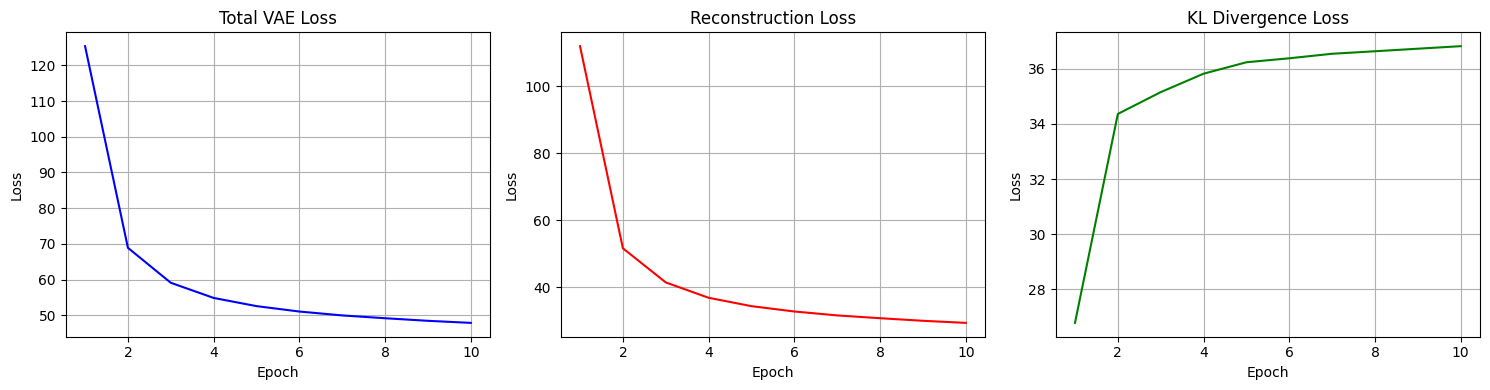

Final losses after 10 epochs:
  Total Loss: 47.85
  Reconstruction: 29.44
  KL Divergence: 36.81


In [49]:
# Plot training losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, len(train_losses) + 1)

# Total loss
axes[0].plot(epochs, train_losses, 'b-', label='Total Loss')
axes[0].set_title('Total VAE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Reconstruction loss
axes[1].plot(epochs, recon_losses, 'r-', label='Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

# KL loss
axes[2].plot(epochs, kl_losses, 'g-', label='KL Divergence')
axes[2].set_title('KL Divergence Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"Final losses after {num_epochs} epochs:")
print(f"  Total Loss: {train_losses[-1]:.2f}")
print(f"  Reconstruction: {recon_losses[-1]:.2f}")
print(f"  KL Divergence: {kl_losses[-1]:.2f}")

## Reconstruction Visualization

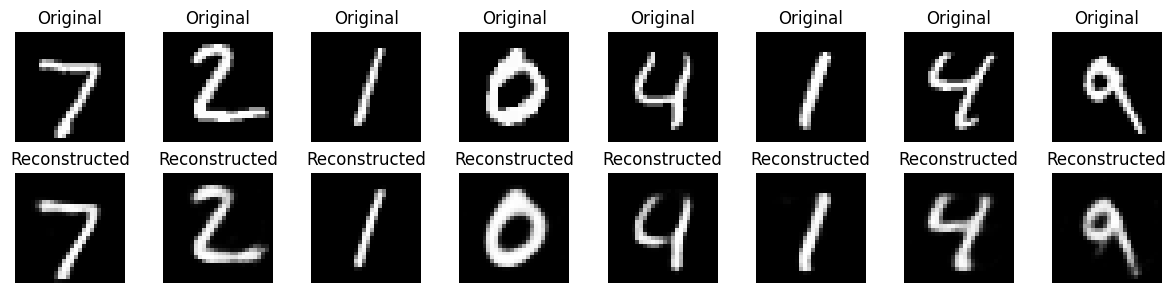

In [50]:
# Show original vs reconstructed images
def show_reconstructions(model, test_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data, _ = next(iter(test_loader))
        data = data.to(device)
        
        # Reconstruct
        recon_batch, _, _ = model(data)
        
        # Convert to numpy and denormalize
        original = data[:num_images].cpu().numpy()
        reconstructed = recon_batch[:num_images].view(-1, 1, 28, 28).cpu().numpy()
        
        # Denormalize from [-1,1] to [0,1]
        original = (original + 1) / 2
        reconstructed = (reconstructed + 1) / 2
        
        # Plot
        fig, axes = plt.subplots(2, num_images, figsize=(12, 3))
        
        for i in range(num_images):
            # Original
            axes[0, i].imshow(original[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

show_reconstructions(model, test_loader)

## Generation from Random Noise

Generating new MNIST digits from random noise...


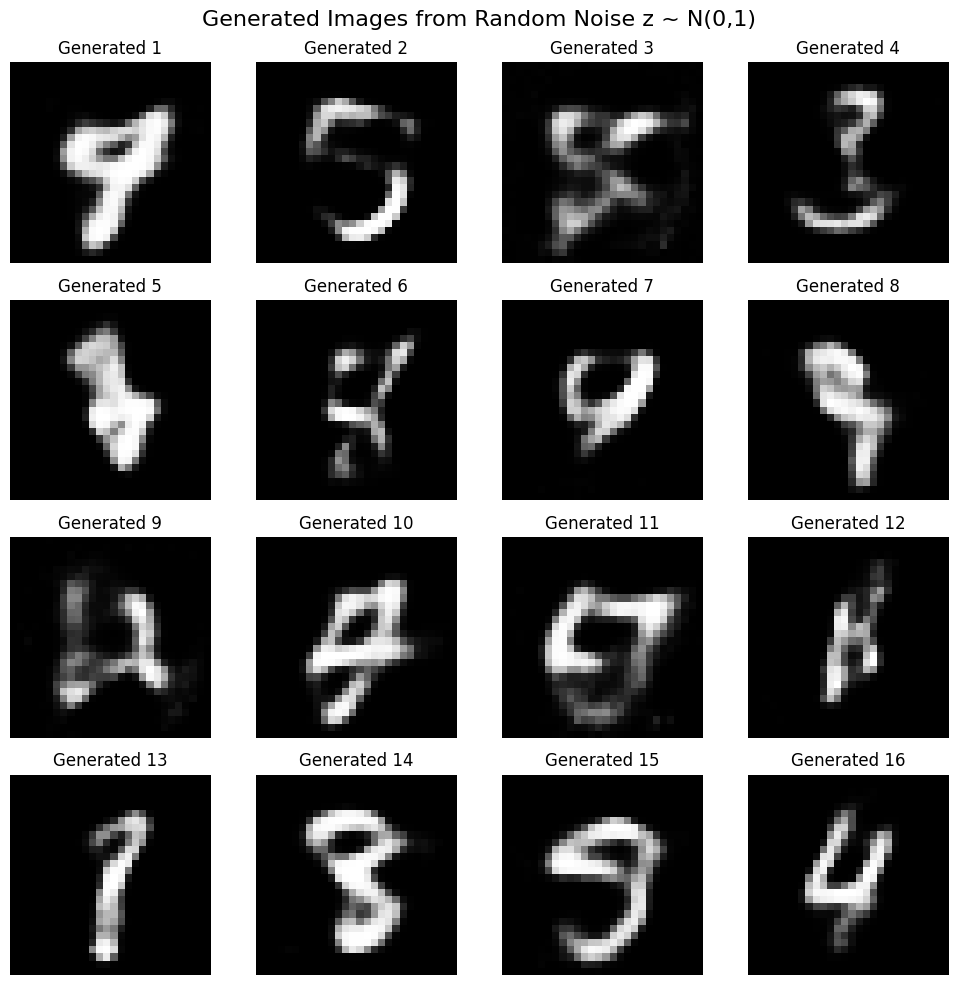

Generated 16 images from random latent codes
Latent codes shape: torch.Size([16, 50])


In [51]:
# Generate new images from random noise
def generate_from_noise(model, num_images=16, latent_dim=20):
    """Generate images by sampling from the prior N(0,1)"""
    model.eval()
    with torch.no_grad():
        # Sample random latent codes from N(0,1)
        z = torch.randn(num_images, latent_dim).to(device)
        
        # Generate images
        generated = model.decode(z)
        
        # Reshape and convert to numpy
        generated = generated.view(-1, 1, 28, 28).cpu().numpy()
        
        # Denormalize from [-1,1] to [0,1]
        generated = (generated + 1) / 2
        
        # Plot generated images
        rows = int(np.sqrt(num_images))
        cols = int(np.ceil(num_images / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
        axes = axes.flatten() if num_images > 1 else [axes]
        
        for i in range(num_images):
            axes[i].imshow(generated[i].squeeze(), cmap='gray')
            axes[i].set_title(f'Generated {i+1}')
            axes[i].axis('off')
        
        # Hide extra subplots
        for i in range(num_images, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Generated Images from Random Noise z ~ N(0,1)', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        return generated, z

# Generate some images!
print("Generating new MNIST digits from random noise...")
generated_images, latent_codes = generate_from_noise(model, num_images=16, latent_dim=50)
print(f"Generated {len(generated_images)} images from random latent codes")
print(f"Latent codes shape: {latent_codes.shape}")

## Latent Space Interpolation

Interpolating between two random points in latent space...


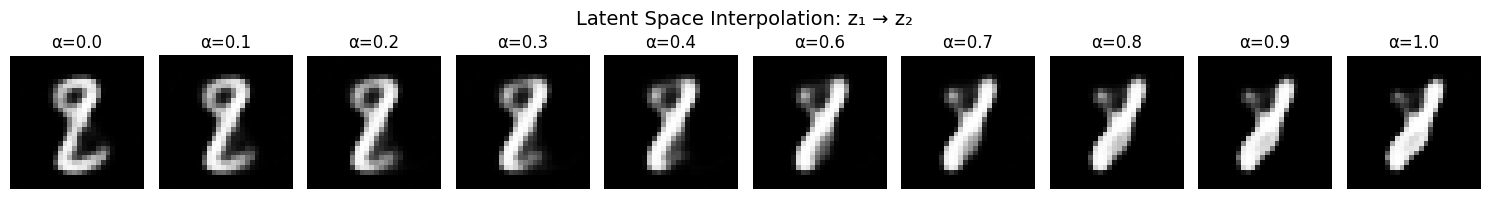

Notice how the digit smoothly transforms from one to another!


In [52]:
# Interpolate between two points in latent space
def interpolate_latent(model, num_steps=10, latent_dim=20):
    """Interpolate between two random points in latent space"""
    model.eval()
    with torch.no_grad():
        # Sample two random latent codes
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)
        
        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(device)
        interpolated_images = []
        
        for alpha in alphas:
            # Linear interpolation: z = (1-α)*z1 + α*z2
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Generate image
            generated = model.decode(z_interp)
            generated = generated.view(28, 28).cpu().numpy()
            generated = (generated + 1) / 2  # Denormalize
            
            interpolated_images.append(generated)
        
        # Plot interpolation
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
        
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'α={alphas[i]:.1f}')
            axes[i].axis('off')
        
        plt.suptitle('Latent Space Interpolation: z₁ → z₂', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        return interpolated_images

# Show interpolation
print("Interpolating between two random points in latent space...")
interpolation = interpolate_latent(model, num_steps=10, latent_dim=50)
print("Notice how the digit smoothly transforms from one to another!")

## 🎨 Understanding Generation Quality

### **What to Look For:**

- **Sharp digits**: Well-trained VAE should generate recognizable numbers
- **Diversity**: Different digits, not just copying training data
- **Smooth interpolation**: Gradual transformation between digits

### **If Generation is Poor:**

- **Train longer**: More epochs usually improve quality
- **Adjust β**: Lower β (e.g., 0.5) for better reconstruction
- **Larger latent space**: Try latent_dim=50 instead of 20
- **Different architecture**: Add more layers or use CNN-based VAE